In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"youssefemad99","key":"c83b593ce22fab36108a01c090e90e78"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:52<00:00, 61.1MB/s]
100% 3.10G/3.10G [00:52<00:00, 63.1MB/s]


In [ ]:
!unzip "/content/breast-histopathology-images.zip" -d "/content/Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: /content/Dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: /content/Dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: /content/Dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: /content/Dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: /content/Dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: /content/Dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: /content/Dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: /content/Dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: /content/Dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflati

In [ ]:
rel_directory = './Dataset/'

In [ ]:
import os
import cv2
import random
def load_data():
    features = []
    label = []
    for folder in os.listdir(rel_directory):
        for labelfolder in os.listdir(rel_directory + folder):
            for img in os.listdir(rel_directory + folder + '/' + labelfolder):
                if len(label) == 15000:
                    return features, label
                label.append(int(labelfolder))
                img_data = cv2.imread(os.path.join(rel_directory, folder, labelfolder, img))
                img_data = cv2.resize(img_data, (50, 50))
                features.append(img_data)

In [ ]:
def shuffle_data(features, label):
    # shuffle both lists
    both = list(zip(features, label))  # join both arrays together
    random.shuffle(both)  # shuffle
    b: object
    a, b = zip(*both)  # disconnect them from each other
    return a, b


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from keras.constraints import maxnorm
from tensorflow.keras import regularizers

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format


In [ ]:
%rm -rf Dataset/IDC_regular_ps50_idx5

In [ ]:
features, label = load_data()
features, label = shuffle_data(features, label)

In [ ]:
X_train = np.array(features[:12000]).reshape(-1, 50, 50, 3)
y_train = np.array(label[:12000])
X_test = np.array(np.array(features[12000:])).reshape(-1, 50, 50, 3)
y_test = np.array(label[12000:])

In [ ]:
def create_model(learning_rate, classification_threshold, METRICS):
    model = models.Sequential()

    # Define the first hidden layer with 20 nodes.
    # model.add(tf.keras.layers.Dense(units=10,
    #                                 activation='softmax',
    #                                 name='Hidden1',
    #                                 activity_regularizer=regularizers.l2(0.01)
    #                                 ))

    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides= (2,2), padding= 'valid'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides= (2,2), padding= 'valid'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())


    model.add(layers.Flatten())

    model.add(layers.Dense(512))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())


    model.add(layers.Dense(1, activation='sigmoid'))



    # checkpoint = ModelCheckpoint('best_model_improved.h5',
    #                              monitor='val_loss',
    #                              verbose=0,
    #                              save_best_only=True,
    #                              mode='auto')
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)

    return model


def train_model(model, train_images, train_labels, test_images, test_labels, epochs, batch_size=None):
    # Split the dataset into features and label.

    history = model.fit(train_images, train_labels, batch_size=batch_size,
                        epochs=epochs, shuffle=True, validation_data=(test_images, test_labels)
                        )

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist


def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.show()
  

In [ ]:
learning_rate = 1e-3
epochs = 30
batch_size = 256
classification_threshold = 0.4
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall']
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision'
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall")
]

In [ ]:
my_model = create_model(learning_rate, classification_threshold, METRICS)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
47/47 [==============================] - 6s 70ms/step - loss: 0.6268 - accuracy: 0.7487 - precision: 0.5406 - recall: 0.6990 - val_loss: 2.4640 - val_accuracy: 0.7207 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
47/47 [==============================] - 2s 48ms/step - loss: 0.4103 - accuracy: 0.8232 - precision: 0.6890 - recall: 0.6753 - val_loss: 3.1339 - val_accuracy: 0.7203 - val_precision: 0.3333 - val_recall: 0.0012
Epoch 3/30
47/47 [==============================] - 2s 48ms/step - loss: 0.3759 - accuracy: 0.8387 - precision: 0.7205 - recall: 0.6949 - val_loss: 1.2440 - val_accuracy: 0.7520 - val_precision: 0.8672 - val_recall: 0.1325
Epoch 4/30
47/47 [==============================] - 2s 48ms/step - loss: 0.3554 - accuracy: 0.8450 - precision: 0.7300 - recall: 0.7109 - val_loss: 0.5784 - val_accuracy: 0.7933 - val_precision: 0.5922 - val_recall: 0.8353
Epoch 5/30
47/47 [==============================] - 2s 48ms/step - loss: 0.3400 - accuracy: 0.8545 -

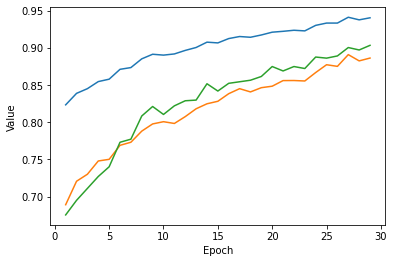

In [ ]:
epoch, hist = train_model(my_model, X_train, y_train, X_test ,y_test ,epochs, batch_size)
plot_curve(epoch, hist, list_of_metrics_to_plot)